In [1]:
import sys
from pathlib import Path

import torch
from torchvision import transforms
from torchvision.datasets import MNIST, EMNIST
from tqdm import trange

In [2]:
# Update path to import src code
sys.path.append("..")

In [3]:
from src import SplitNN, ConvAttackModel, plot_images, AttackDataset

In [4]:
project_root = Path.cwd().resolve().parent

In [5]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

---
# 4. Adding noise during posttraining with constant attack dataset
In previous experiments,
we trained the attacker by sampling
new intermediate representations of the data (from the SplitNN)
for each epoch.
This may help the attacker learn to remove the additive noise.
In a practical setting we could reduce an attacker's ability
to query the model with the same data multiple times
by limiting queries,
therefore an attack model would have to be trained using a constant dataset.
In this experiment, we will train the attacker using a constant datset,
on a target model posttrained with noise.

## Load target model
Load a model trained without noise

In [6]:
noiseless_model_path = project_root / "models" / "splitnn_00noise.pth"

In [7]:
noise = 3.0
target_model = SplitNN(noise)

checkpoint = torch.load(noiseless_model_path)
target_model.load_state_dict(checkpoint["model_state_dict"])

target_model = target_model.to(device)
target_model.eval()
target_model

SplitNN(
  (part1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
  )
  (part2): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

## Freeze first part of network

In [8]:
for param in target_model.part1.parameters():
    param.requires_grad = False

## Continue training

In [9]:
data_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
)

In [10]:
mnist_train = MNIST(project_root / "data", download=True, train=True, transform=data_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=128)

In [11]:
optimiser = torch.optim.Adam(target_model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(4):
    train_loss = 0.0

    correct = 0
    total = 0

    target_model.train()
    for batch_idx, (inputs, targets) in enumerate(mnist_train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimiser.zero_grad()

        outputs = target_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Loss: {train_loss / len(mnist_train_loader):.3f}")
    print(f"Accuracy: {100 * correct / total:.3f}")

Loss: 1.500
Accuracy: 96.203
Loss: 1.496
Accuracy: 96.563
Loss: 1.494
Accuracy: 96.708
Loss: 1.493
Accuracy: 96.817


## Confirm target model performance

In [12]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[:5_000]
mnist_test.targets = mnist_test.targets[:5_000]

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000)

In [13]:
target_test_correct = 0
target_test_total = 0

target_model.eval()
for data, targets in mnist_test_loader:
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        outputs = target_model(data)

    target_test_correct += outputs.max(1)[1].eq(targets).sum().item()
    target_test_total += outputs.size(0)

target_test_accuracy = 100 * target_test_correct / target_test_total
print(f"Target model accuracy: {target_test_accuracy:.3f}")

Target model accuracy: 95.360


## Compare to noiseless model
How does adding this noise compare to noiseless model?

In [14]:
noiseless_model = SplitNN(0.0)

checkpoint = torch.load(noiseless_model_path)
noiseless_model.load_state_dict(checkpoint["model_state_dict"])

noiseless_model = noiseless_model.to(device)
noiseless_model.eval()

SplitNN(
  (part1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
  )
  (part2): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

In [15]:
noiseless_test_correct = 0
noiseless_test_total = 0

for data, targets in mnist_test_loader:
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        outputs = noiseless_model(data)

    noiseless_test_correct += outputs.max(1)[1].eq(targets).sum().item()
    noiseless_test_total += outputs.size(0)

noiseless_test_accuracy = 100 * noiseless_test_correct / noiseless_test_total
print(f"Noiseless model accuracy: {noiseless_test_accuracy:.3f}")

Noiseless model accuracy: 98.380


## Create attacker dataset

In [16]:
emnist_train = EMNIST(project_root / "data", "letters", download=True, train=True, transform=data_transform)
emnist_train.data = emnist_train.data[: 500]
emnist_train.targets = emnist_train.targets[: 500]

emnist_loader = torch.utils.data.DataLoader(emnist_train, batch_size=128)

In [17]:
attack_dataset = AttackDataset()

for actual_data, _ in emnist_loader:
    actual_data = actual_data.to(device)

    # Get target model output
    with torch.no_grad():
        intermediate_data = target_model.encode(actual_data)

    attack_dataset.push(intermediate_data, actual_data)

# Create a data loader
attack_loader = torch.utils.data.DataLoader(attack_dataset, batch_size=128)

## Train attacker
We will train the attack model on EMNIST images.
These are similar enough to MNIST for the attack to work in principle,
but different enough to simulate a real-world attack setting (unknown training data).

In [18]:
attack_model = ConvAttackModel().to(device)
attack_model.train()
attack_optim = torch.optim.Adam(attack_model.parameters(), lr=1e-4)

for epoch in trange(5):
    for intermediate_data, data in attack_loader:
        attack_optim.zero_grad()

        data = data.to(device)
        intermediate_data = intermediate_data.to(device)

        reconstructed_data = attack_model(intermediate_data)

        loss = ((reconstructed_data - data)**2).mean()
        loss.backward()
        attack_optim.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


## Train attacker on noiseless model

In [19]:
noiseless_attack_model = ConvAttackModel().to(device)
noiseless_attack_model.train()
noiseless_attack_optim = torch.optim.Adam(noiseless_attack_model.parameters(), lr=1e-4)

for epoch in trange(5):
    for data, _ in emnist_loader:
        noiseless_attack_optim.zero_grad()

        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            intermediate_data = noiseless_model.encode(data)
            

        reconstructed_data = noiseless_attack_model(intermediate_data)

        loss = ((reconstructed_data - data)**2).mean()
        loss.backward()
        noiseless_attack_optim.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.40s/it]


## Visualise reconstruction

In [20]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[5_000:]
mnist_test.targets = mnist_test.targets[5_000:]

### Noisy model

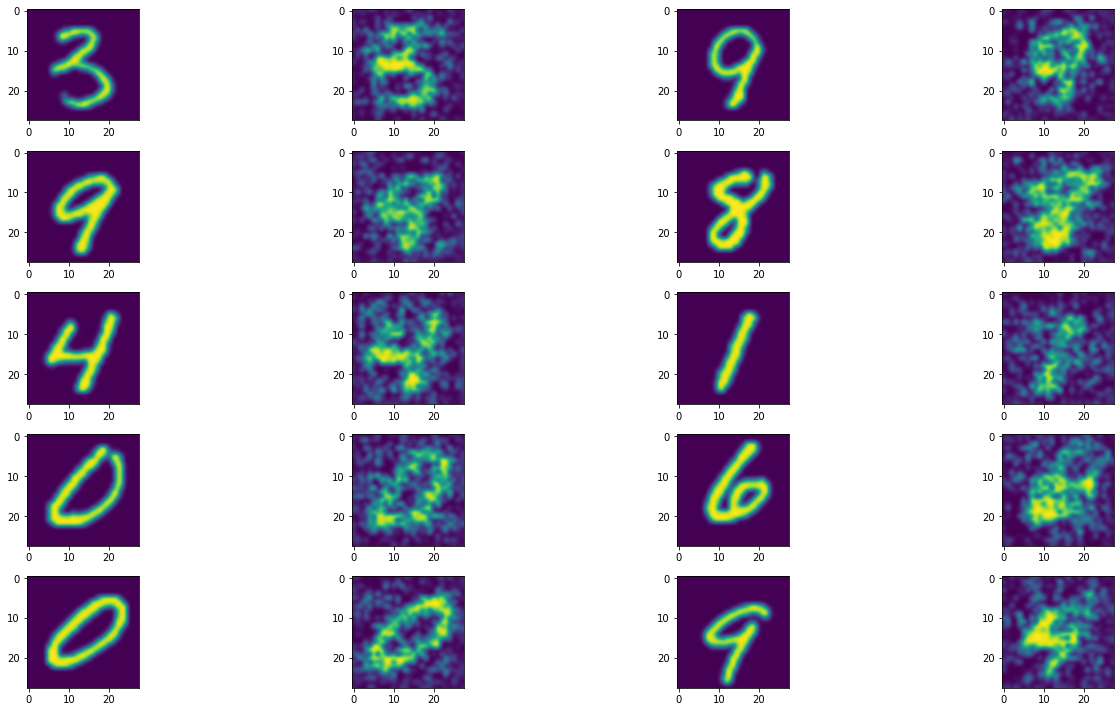

In [21]:
ims = []

for i in range(10):
    image, _ = mnist_test[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims)

### Compare noisy and noiseless models

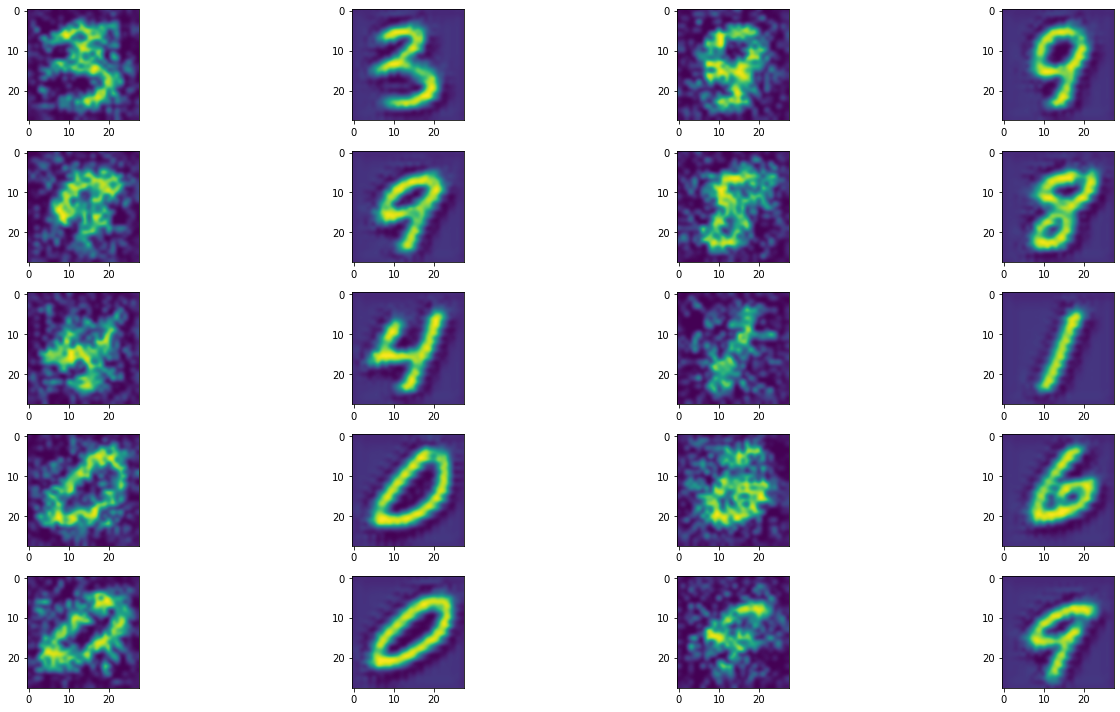

In [22]:
ims = []

for i in range(10):
    image, _ = mnist_test[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model(intermediate)

        intermediate_noiseless = noiseless_model.encode(image.unsqueeze(0))
        reconstructed_noiseless = noiseless_attack_model(intermediate_noiseless) 

    reconstructed = reconstructed.squeeze(0)
    reconstructed_noiseless = reconstructed_noiseless.squeeze(0)
    ims.extend([reconstructed, reconstructed_noiseless])

plot_images(ims)